# Projeto 3#
#### Antonio Fonseca, Daniel Pucciariello e José Bechara.####

## Tema:##
*Prever se um projeto do kickstarter irá ser bem sucedido ou não.*

Técnica: Classificador.

https://www.kaggle.com/kemical/kickstarter-projects


In [1]:
%matplotlib notebook
%reset -f


import pandas as pd
import numpy as np
from scipy.stats import norm, probplot
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing

from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

from datetime import datetime

%matplotlib inline

In [2]:
def dummify(data, column_name):
    """
        Converte a coluna column_name em dummies / one-hot e as adiciona ao dataframe
        retorna uma copia do  df original *sem* a coluna que foi dummified
    """
    df = data.copy()
    # Nota: se você for um econometrista, pode se interessar por usar a opção dropFirst = True na get_dummies
    df2 = pd.concat([df.drop(column_name, axis=1), pd.get_dummies(data[column_name], prefix=column_name)], axis=1)
    return df2

def calculo_dias(date1,date2):
    date_format = "%Y-%m-%d %H:%M:%S"
    a = datetime.strptime(date1, date_format)
    b = datetime.strptime(date2, date_format)
    delta= a-b
    return delta.days

## Leitura dos dataframes:

In [3]:
data = pd.read_csv('ks-projects-201801.csv', parse_dates=['deadline', 'launched'])
data1 = pd.read_csv('ks-projects-201801.csv', parse_dates=['deadline', 'launched'])

In [4]:
data = data[data.state != "live"]# ARRUMAR ISSO
# data_live=data1.query('state == "live"')

data_boolean = data.replace("canceled", "failed").replace("undefined", "failed").replace("suspended", "failed")

In [5]:
data.main_category.value_counts()

Film & Video    63253
Music           51637
Publishing      39575
Games           34944
Technology      32192
Design          29765
Art             27959
Food            24418
Fashion         22566
Theater         10872
Comics          10743
Photography     10731
Crafts           8733
Journalism       4724
Dance            3750
Name: main_category, dtype: int64

### Dataframe cru:

In [6]:
data.head(3)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00


### Categorias:

In [7]:
data.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

In [8]:
data.category = data.category.astype('category')
data.main_category = data.main_category.astype('category')
data.state = data.state.astype('category')
data.country = data.country.astype('category')

### Porcentagem de sucesso nos projetos:

In [9]:
failed=data_boolean.state.value_counts()[0]
sucessful=data_boolean.state.value_counts()[1]
print("Número de projetos que falharam:", failed)
print("Número de projetos bem sucedidos:", sucessful)
print("Porcentagem de sucesso:", 100*sucessful/(failed + sucessful), "%")

Número de projetos que falharam: 241906
Número de projetos bem sucedidos: 133956
Porcentagem de sucesso: 35.639676264160784 %


### Representação gráfica desses dados:

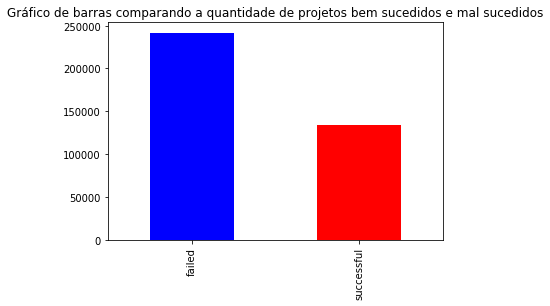

In [10]:
data_boolean.state.value_counts().plot(kind='bar', color=('blue', 'red'), legend=False)
plt.title("Gráfico de barras comparando a quantidade de projetos bem sucedidos e mal sucedidos")
plt.show();

### "Dummyficando" as variáveis qualitativas:

In [11]:
data_dummified = dummify(data, "main_category")
data_dummified = dummify(data_dummified, "state")

data_dummified.columns

Index(['ID', 'name', 'category', 'currency', 'deadline', 'goal', 'launched',
       'pledged', 'backers', 'country', 'usd pledged', 'usd_pledged_real',
       'usd_goal_real', 'main_category_Art', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Design',
       'main_category_Fashion', 'main_category_Film & Video',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'state_canceled', 'state_failed',
       'state_successful', 'state_suspended', 'state_undefined'],
      dtype='object')

In [12]:
#quantitativas = data_dummified.loc[:,['goal', 'pledged', 'launched']
quantitativas = data_dummified.loc[:,['goal', 'state_successful', 'main_category_Art', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Design',
       'main_category_Fashion', 'main_category_Film & Video',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater' ]]
quantitativas.head(5)

,goal,state_successful,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
0,1000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,30000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,45000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,5000.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,19500.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


### Calculando o tempo de duração da campanha:

In [13]:
delta_t =[]
for e,i in zip(data.deadline, data.launched):
    e = str(e)
    i = str(i)
    a = calculo_dias(e,i)
    delta_t.append(a)

In [14]:
data_delta_t=quantitativas
data_delta_t["deltat (days)"]=delta_t
data_delta_t.head()

,goal,state_successful,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,deltat (days)
0,1000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,58
1,30000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,59
2,45000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,44
3,5000.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,29
4,19500.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,55


In [15]:
y = quantitativas.state_successful == 1 # Selecionando apenas as campanhas que obtiveram sucesso

# Regressão Logística:

### Criação de diversos dataframes para serem utilizados pelo modelo e posteriormente testarem sua acurácia.

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_delta_t, y, test_size=0.1, random_state=112)

In [17]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((338275, 18), (338275,), (37587, 18), (37587,))

In [18]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', multi_class='auto',max_iter=200)

### Verificando se a proporção de sucessos e falhas no conjunto de treinamento é similar à proporção dos mesmos no conjunto de testes.

In [19]:
conta_treinamento = pd.Series(y_train).value_counts()
conta_treinamento

False    217539
True     120736
Name: state_successful, dtype: int64

In [20]:
conta_teste = pd.Series(y_test).value_counts()
conta_teste

False    24367
True     13220
Name: state_successful, dtype: int64

In [21]:
conta_treinamento[True] / conta_treinamento[False]

0.5550085272066159

In [22]:
conta_teste[True] / conta_teste[False]

0.5425370377970206

In [23]:
X_train=X_train.drop(columns=['state_successful']) # removendo coluna de estado do dataframe de treinamento

In [24]:
X_test=X_test.drop(columns=['state_successful'])# removendo coluna de estado do dataframe de teste 

In [25]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
y_pred = model.predict(X_test)

# Calcula acurácia.
acc = accuracy_score(y_test, y_pred)

print('Acurácia: {}'.format(acc))

Acurácia: 0.6482826509165402


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rdm_forest = RandomForestClassifier(n_estimators=100)
rdm_forest = rdm_forest.fit(X_train,y_train)
rdm_forest

In [ ]:
y_pred = rdm_forest.predict(X_test)

# Calcula acurácia.
acc = accuracy_score(y_test, y_pred)

print('Acurácia: {}'.format(acc))